## Bag of Words Meets Bags of Popcorn
### Tutorial 2. Word2Vec

목차
- 1. Word2Vec 소개
- 2. Word2Vec 학습 : ★Gensim을 통해 벡터화 & t-SNE로 시각화
- 3. Word2Vec 모델결과 탐색
- 4. Word2Vec으로 벡터화 한 단어를 ★t-SNE 를 통해 시각화
- 5. ★평균 feature vector 구한 후 ★랜덤포레스트로 학습해보자
- ★캐글에 제출

# 1. Word2Vec 소개

## Word2Vec이란(Word Embedding to Vector)


- tutorial1 : one hot encoding(예 [0000001000]) 혹은 Bag of Word에서 vector size가 매우 크고 sparse 하므로 neural net 성능이 잘 나오지 않는다.

- ★Word2Vec : 주위 단어가 비슷하면 해당 단어의 의미는 유사하다 라는 아이디어

- 단어를 트레이닝 시킬 때 주위 단어를 label로 매치하여 최적화 시킨다.

- 단어를 의미를 내포한 dense vector로 매칭 시키는 것

- 개념간 유사성 : Word2Vec은 분산 된 텍스트 표현을 사용하여 개념 간 유사성을 본다. 
  - 예를 들어, 파리와 프랑스가 베를린과 독일이 (수도와 나라) 같은 방식으로 관련되어 있음을 이해한다.

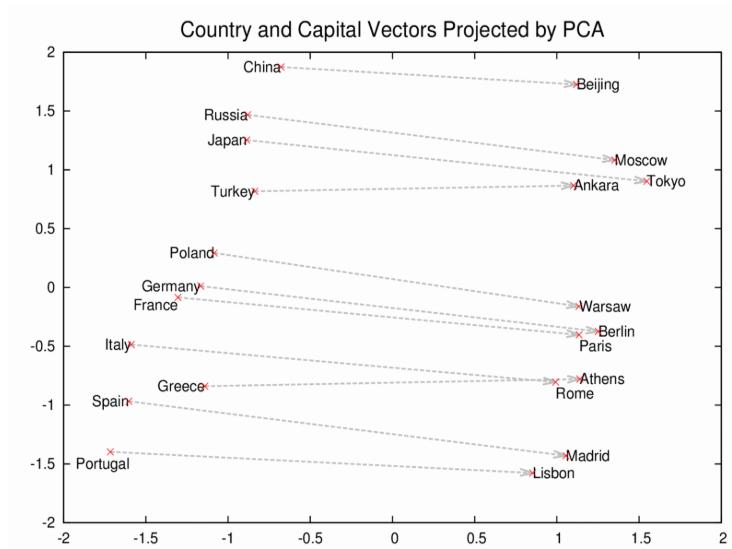

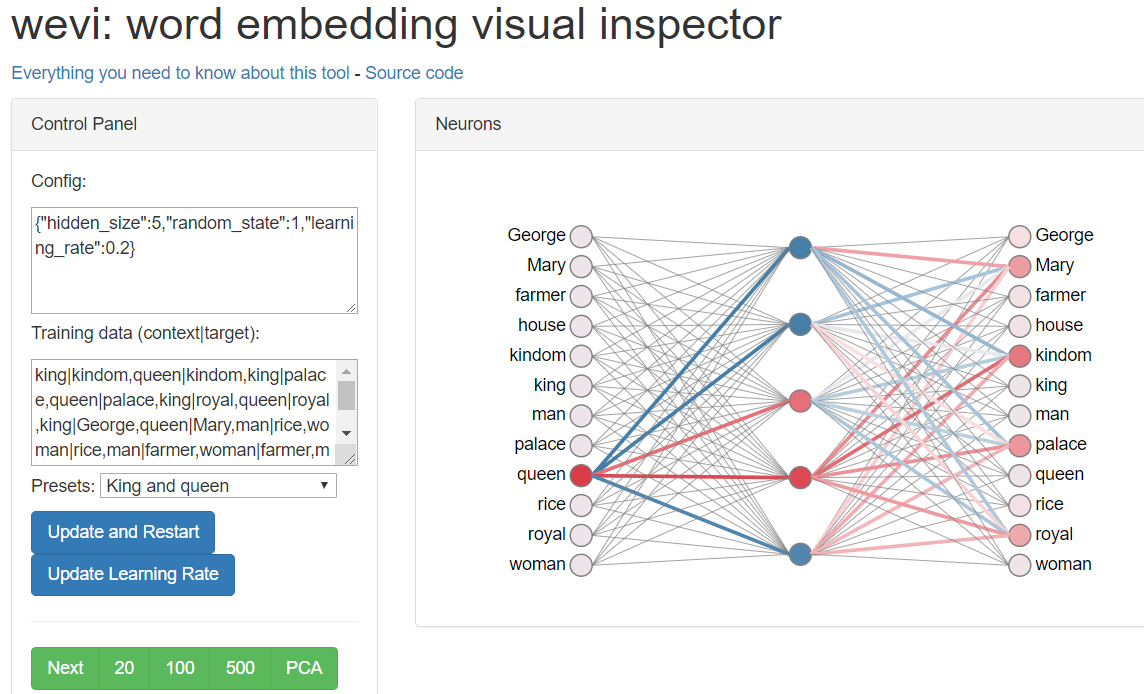

In [12]:
from IPython.display import Image
Image("image/word embedding.PNG")
# King과 Queen의 관계를 학습시킨다. -> Man과 Woman의 관계와 비슷 

### Word2Vec은 크게 2가지로 나뉜다. CBOW와 Skip-Gram기법이 있다.

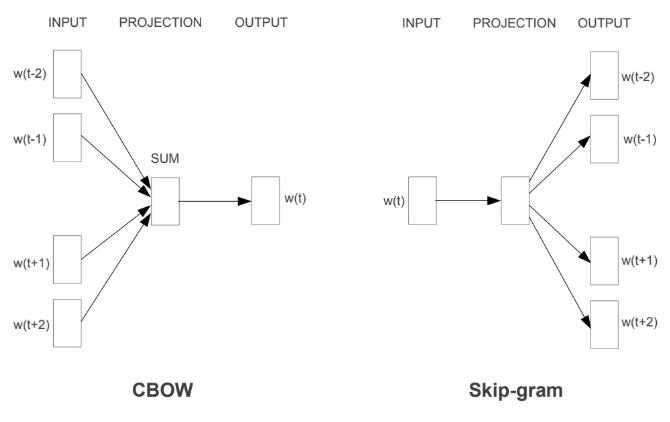

## Word2Vec 참고자료

- word2vec 모델 · 텐서플로우 문서 한글 번역본
- ★Word2Vec으로 문장 분류하기_ratsgo's blog (https://ratsgo.github.io/natural%20language%20processing/2017/03/08/word2vec/)
- Efficient Estimation of Word Representations in Vector Space
- Distributed Representations of Words and Phrases and their Compositionality
- CS224n: Natural Language Processing with Deep Learning     (http://web.stanford.edu/class/cs224n/syllabus.html)
- Word2Vec Tutorial - The Skip-Gram Model · Chris McCormick

### Gensim

- 파이썬에서 Word2Vec 사용가능하게 해줌(단어 벡터화)

- gensim: models.word2vec – Deep learning with word2vec      
  (https://radimrehurek.com/gensim/models/word2vec.html)
- gensim: Tutorials                                          
  (https://radimrehurek.com/gensim/tutorial.html)
- 한국어와 NLTK, Gensim의 만남 - PyCon Korea 2015           
  (https://www.lucypark.kr/docs/2015-pyconkr/#1)

In [24]:
# 출력이 너무 길어지지 않게하기 위해 찍지 않도록 했으나 실제 학습 할 때는 아래 두 줄을 주석처리 하는 것을 권장한다.
import warnings
warnings.filterwarnings('ignore')

In [25]:
import pandas as pd

train = pd.read_csv('data/labeledTrainData.tsv', 
                    header=0, delimiter='\t', quoting=3)
test = pd.read_csv('data/testData.tsv', 
                   header=0, delimiter='\t', quoting=3)
unlabeled_train = pd.read_csv('data/unlabeledTrainData.tsv', 
                              header=0, delimiter='\t', quoting=3)

In [26]:
print(train.shape)
print(test.shape)
print(unlabeled_train.shape)

(25000, 3)
(25000, 2)
(50000, 2)


In [27]:
print(train['review'].size)
print(test['review'].size)
print(unlabeled_train['review'].size)

25000
25000
50000


In [28]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [29]:
# test데이터에는 train에 있는 평점정보인 sentiment가 없다.
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


### 딥러닝 기법 Word2Vec 소개 (8분 12초~)
### ★KaggleWord2VecUtility.py 파일이 필요

In [30]:
from KaggleWord2VecUtility import *

In [31]:
train['review'][0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

### stopwords 제거하지 않은 버전 : review_to_wordlist
(stopwords 제거한 버전 : review_to_wordlist2)

In [21]:
KaggleWord2VecUtility.review_to_wordlist(train['review'][0])[:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [22]:
sentences = []
for review in train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(
        review, remove_stopwords=False)

In [23]:
for review in unlabeled_train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(
        review, remove_stopwords=False)

In [ ]:
len(sentences)

In [44]:
sentences[0][:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [45]:
sentences[1][:10]

['mayb', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into']

#### => 이제 전처리를 거쳐 파싱된 문장의 목록으로 모델을 학습시킬 준비가 되었다.

# 2. Word2Vec 학습 : Gensim을 통해 벡터화 & t-SNE로 시각화

- 단어간의 문맥을 학습 : stopwords가 있는 것이 문맥 이해하기 좋아서 남겨두고 전처리함

Gensim : 파이썬에서 제공하는 Word2Vec 라이브러리
(https://radimrehurek.com/gensim/models/word2vec.html)

### Word2Vec 모델의 파라메터

### 학습 시작

In [32]:
import logging          # Word2Vec 모델을 학습하는 동안 로그를 찍도록 설정
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [33]:
# 파라메터값 지정
num_features = 300   # 문자 벡터 차원 수
min_word_count = 40  # 최소 문자 수
num_workers = 4      # 병렬 처리 스레드 수
context = 10         # 문자열 창 크기
downsampling = 1e-3  # 문자 빈도 수 Downsample

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
model

2018-12-24 16:28:46,035 : INFO : 'pattern' package not found; tag filters are not available for English
2018-12-24 16:28:46,040 : INFO : collecting all words and their counts
2018-12-24 16:28:46,041 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-12-24 16:28:46,082 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 12465 word types
2018-12-24 16:28:46,121 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 17070 word types
2018-12-24 16:28:46,161 : INFO : PROGRESS: at sentence #30000, processed 671314 words, keeping 20370 word types
2018-12-24 16:28:46,205 : INFO : PROGRESS: at sentence #40000, processed 897814 words, keeping 23125 word types
2018-12-24 16:28:46,241 : INFO : PROGRESS: at sentence #50000, processed 1116962 words, keeping 25365 word types
2018-12-24 16:28:46,287 : INFO : PROGRESS: at sentence #60000, processed 1338403 words, keeping 27283 word types
2018-12-24 16:28:46,325 : INFO : PROGRESS: at senten

2018-12-24 16:28:49,172 : INFO : PROGRESS: at sentence #710000, processed 15880377 words, keeping 82561 word types
2018-12-24 16:28:49,214 : INFO : PROGRESS: at sentence #720000, processed 16105664 words, keeping 83037 word types
2018-12-24 16:28:49,255 : INFO : PROGRESS: at sentence #730000, processed 16332045 words, keeping 83572 word types
2018-12-24 16:28:49,297 : INFO : PROGRESS: at sentence #740000, processed 16553078 words, keeping 84128 word types
2018-12-24 16:28:49,337 : INFO : PROGRESS: at sentence #750000, processed 16771405 words, keeping 84600 word types
2018-12-24 16:28:49,379 : INFO : PROGRESS: at sentence #760000, processed 16990809 words, keeping 85069 word types
2018-12-24 16:28:49,418 : INFO : PROGRESS: at sentence #770000, processed 17217946 words, keeping 85645 word types
2018-12-24 16:28:49,458 : INFO : PROGRESS: at sentence #780000, processed 17448092 words, keeping 86161 word types
2018-12-24 16:28:49,495 : INFO : PROGRESS: at sentence #790000, processed 176751

2018-12-24 16:29:34,762 : INFO : EPOCH 4 - PROGRESS: at 7.13% examples, 912035 words/s, in_qsize 7, out_qsize 0
2018-12-24 16:29:35,775 : INFO : EPOCH 4 - PROGRESS: at 14.45% examples, 917806 words/s, in_qsize 8, out_qsize 0
2018-12-24 16:29:36,785 : INFO : EPOCH 4 - PROGRESS: at 21.52% examples, 911496 words/s, in_qsize 7, out_qsize 0
2018-12-24 16:29:37,788 : INFO : EPOCH 4 - PROGRESS: at 28.53% examples, 907934 words/s, in_qsize 8, out_qsize 1
2018-12-24 16:29:38,787 : INFO : EPOCH 4 - PROGRESS: at 35.27% examples, 897878 words/s, in_qsize 7, out_qsize 0
2018-12-24 16:29:39,786 : INFO : EPOCH 4 - PROGRESS: at 41.59% examples, 883897 words/s, in_qsize 7, out_qsize 0
2018-12-24 16:29:40,790 : INFO : EPOCH 4 - PROGRESS: at 48.27% examples, 880871 words/s, in_qsize 7, out_qsize 0
2018-12-24 16:29:41,801 : INFO : EPOCH 4 - PROGRESS: at 54.99% examples, 878301 words/s, in_qsize 7, out_qsize 0
2018-12-24 16:29:42,808 : INFO : EPOCH 4 - PROGRESS: at 61.52% examples, 875072 words/s, in_qsize

### 모델 저장 : Word2Vec 모델 학습이 완료된 후 모델을 저장한다.

In [34]:
# 학습이 완료 되면 필요없는 메모리를 unload 시킨다.
model.init_sims(replace=True)

# (위에서) 파라메터값 지정
# num_features = 300   # 문자 벡터 차원 수
# min_word_count = 40  # 최소 문자 수
# num_workers = 4      # 병렬 처리 스레드 수
# context = 10         # 문자열 창 크기
# downsampling = 1e-3  # 문자 빈도 수 Downsample

model_name = '300features_40minwords_10text'
# model_name = '300features_50minwords_20text'

model.save(model_name)

2018-12-24 16:30:30,031 : INFO : precomputing L2-norms of word weight vectors
2018-12-24 16:30:30,124 : INFO : saving Word2Vec object under 300features_40minwords_10text, separately None
2018-12-24 16:30:30,124 : INFO : not storing attribute vectors_norm
2018-12-24 16:30:30,124 : INFO : not storing attribute cum_table
2018-12-24 16:30:30,404 : INFO : saved 300features_40minwords_10text


In [35]:
pwd

'C:\\Users\\runia\\Desktop\\01.화장품_리뷰_추천_프로젝트\\inf_movie\\tutorial2(Word2Vec)'

# 3. Word2Vec 모델 결과 탐색

In [36]:
# 유사도가 없는 단어 추출  : model.wv.doesnt_match()
# : man / woman / child / kitchen 중 서로 다른 단어 하나는?
model.wv.doesnt_match('man woman child kitchen'.split())

'kitchen'

In [37]:
# 유사도가 없는 단어 추출 : 나라 이름 중에 껴있는 berlin을 골라라
model.wv.doesnt_match("france england germany berlin".split())

2018-12-24 16:32:25,630 : WARNING : vectors for words {'germany', 'france'} are not present in the model, ignoring these words


'berlin'

In [38]:
# 가장 유사한 단어를 추출 : model.wv.most_similar()
model.wv.most_similar("man")

[('woman', 0.6327219009399414),
 ('lad', 0.5148433446884155),
 ('businessman', 0.5097289085388184),
 ('ladi', 0.5013986825942993),
 ('millionair', 0.500208854675293),
 ('boxer', 0.47402307391166687),
 ('widow', 0.4583044648170471),
 ('loner', 0.4581211805343628),
 ('men', 0.4549720287322998),
 ('lawyer', 0.448112428188324)]

In [39]:
model.wv.most_similar("queen")

[('princess', 0.6021580100059509),
 ('latifah', 0.5975069403648376),
 ('victoria', 0.5846365094184875),
 ('eva', 0.5661280751228333),
 ('maid', 0.5534824132919312),
 ('stepmoth', 0.5469211339950562),
 ('goddess', 0.5452826619148254),
 ('regina', 0.5423941016197205),
 ('princ', 0.5415288805961609),
 ('mistress', 0.5403871536254883)]

In [40]:
model.wv.most_similar("awful")

KeyError: "word 'awful' not in vocabulary"

In [41]:
model.wv.most_similar("film")

[('movi', 0.8526814579963684),
 ('flick', 0.5988678932189941),
 ('documentari', 0.5656421780586243),
 ('pictur', 0.5451782941818237),
 ('cinema', 0.5215441584587097),
 ('it', 0.48845967650413513),
 ('masterpiec', 0.4811908006668091),
 ('genr', 0.4758594036102295),
 ('sequel', 0.46993908286094666),
 ('effort', 0.4682595133781433)]

In [42]:
# model.wv.most_similar("happy")
model.wv.most_similar("happi")    # stemming 처리 시

[('unhappi', 0.45299291610717773),
 ('sad', 0.4058094024658203),
 ('bitter', 0.4052060842514038),
 ('satisfi', 0.3934350311756134),
 ('happier', 0.39321839809417725),
 ('lucki', 0.37449151277542114),
 ('afraid', 0.373945415019989),
 ('proud', 0.36302947998046875),
 ('joy', 0.3624190092086792),
 ('sadden', 0.3617079555988312)]

# 4. Word2Vec으로 벡터화 한 단어를 ★t-SNE 를 통해 시각화

In [44]:
# 참고 https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g
mpl.rcParams['axes.unicode_minus'] = False   # 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처

# 위에서 만든 model 가져오기
model_name = '300features_40minwords_10text'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))               # feature 수 : 11986개
print(X[0][:10])            # 첫번째 데이터에서 10개만 찍어본다.
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])   # 100개의 단어로 학습 시켜서 X_tsne 변수에 저장.
# X_tsne = tsne.fit_transform(X)

2018-12-24 16:36:02,921 : INFO : loading Doc2Vec object from 300features_40minwords_10text
2018-12-24 16:36:03,144 : INFO : loading wv recursively from 300features_40minwords_10text.wv.* with mmap=None
2018-12-24 16:36:03,144 : INFO : setting ignored attribute vectors_norm to None
2018-12-24 16:36:03,145 : INFO : loading vocabulary recursively from 300features_40minwords_10text.vocabulary.* with mmap=None
2018-12-24 16:36:03,145 : INFO : loading trainables recursively from 300features_40minwords_10text.trainables.* with mmap=None
2018-12-24 16:36:03,146 : INFO : setting ignored attribute cum_table to None
2018-12-24 16:36:03,146 : INFO : loaded 300features_40minwords_10text


11986
[-0.01864596 -0.00484975 -0.05440833  0.08823697 -0.03615446  0.04860715
  0.16364914 -0.00894162 -0.01429981 -0.02272563]


#### => tSNE 사용 완료

In [45]:
# 각 단어가 어디에 위치하는지 x, y 좌표로 찍어준다.
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

In [46]:
df.head(10)

,x,y
with,1.685668,-1.387694
all,-3.311261,-0.654983
this,-5.263726,2.438885
stuff,-3.120702,0.547192
go,0.400911,5.789617
down,5.171215,-0.057573
at,4.600029,-1.815627
the,-1.897902,-1.759568
moment,-6.159959,-0.548974
mj,-2.891349,-7.523944


### => 단어들이 각각 x,y 좌표에 위와 같이 나타난다.

## 단어 벡터들을 Scatter 그래프로 시각화 해보자.

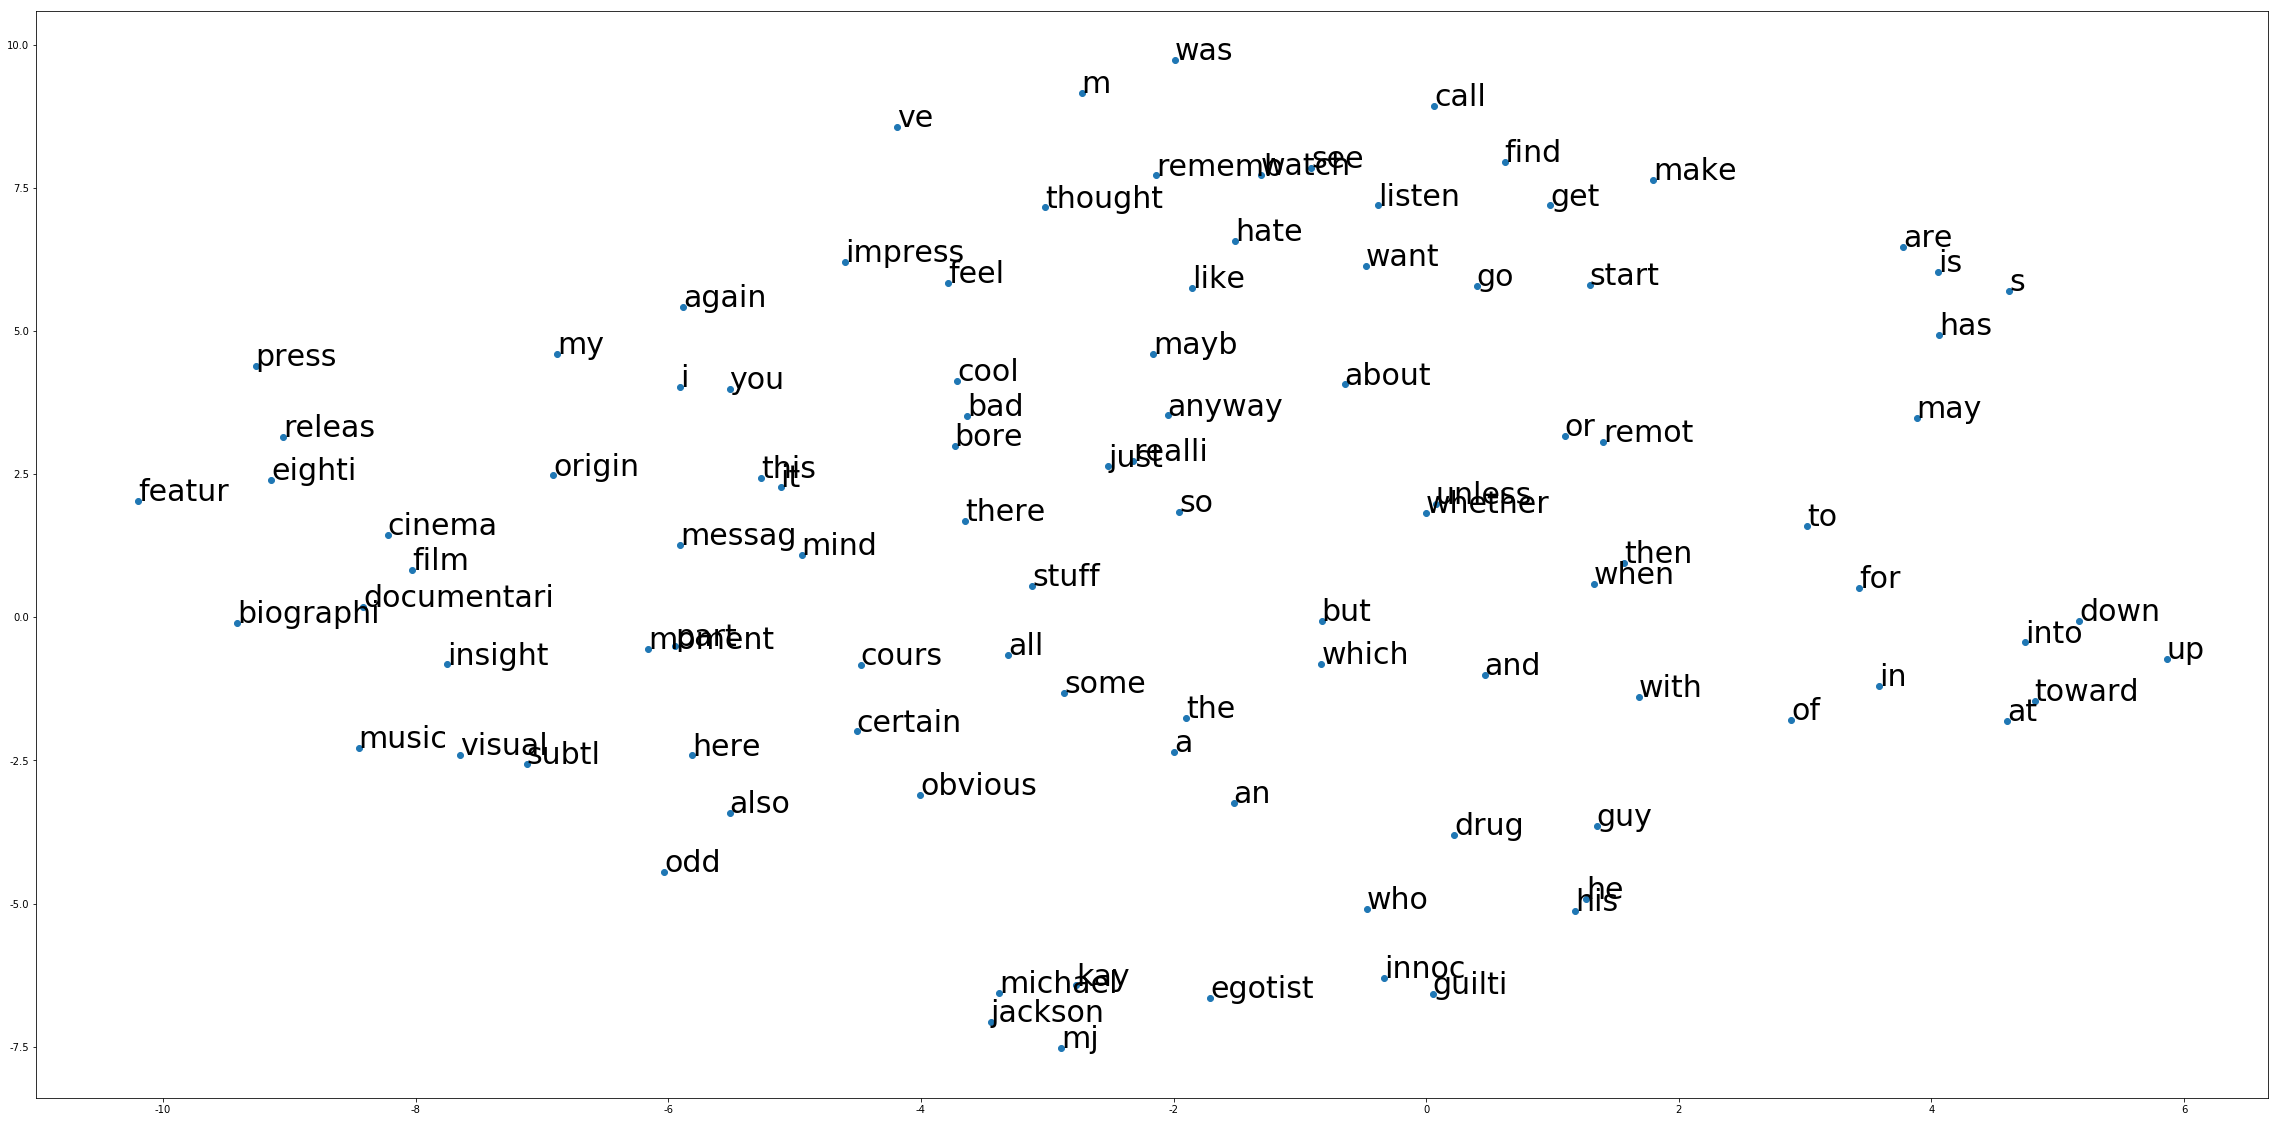

In [47]:
# 첫번째 리뷰로 그려보는 것인데, 마이클 잭슨에 대한 리뷰였음.

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()       

### => 마이클잭슨 관련, 조사 집단, 방향 단어들 등이 모여있음을 확인

## 5. Tutorial 2-3. 평균 feature vector 구한 후 ★랜덤포레스트로 학습해보자

In [49]:
import numpy as np

# 주어진 문장에서 단어 벡터의 평균을 구하는 함수
def makeFeatureVec(words, model, num_features):
    
    # 속도를 위해 0으로 채운 배열로 초기화 한다.
    featureVec = np.zeros((num_features,),dtype="float32")

    nwords = 0.
    # Index2word는 모델의 사전에 있는 단어명을 담은 리스트이다.
    # 속도를 위해 set 형태로 초기화 한다.
    index2word_set = set(model.wv.index2word)
    # 루프를 돌며 모델 사전에 포함이 되는 단어라면 피처 벡터에 추가한다.
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
            
    # 결과를 단어수로 나누어 평균을 구한다.
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [50]:
def getAvgFeatureVecs(reviews, model, num_features):
    # 리뷰 단어 목록의 각각에 대한 평균 feature 벡터를 계산하고 
    # 2D numpy 배열을 반환한다.
    
    # 카운터를 초기화 한다.
    counter = 0.
    # 속도를 위해 2D 넘파이 배열을 미리 할당한다.
    reviewFeatureVecs = np.zeros(
        (len(reviews),num_features),dtype="float32")
    
    for review in reviews:
       # 매 1000개 리뷰마다 상태를 출력
       if counter%1000. == 0.:
           print("Review %d of %d" % (counter, len(reviews)))
        
       # 평균 피처 벡터를 만들기 위해 위에서 정의한 함수를 호출한다.
       reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, \
           num_features)
        
       # 카운터를 증가시킨다.
       counter = counter + 1.
    return reviewFeatureVecs

In [51]:
# 멀티스레드로 4개의 워커를 사용해 처리한다. 작업 끝나면 1개로 합침 (apply_by_multiprocessing 함수)
def getCleanReviews(reviews):
    clean_reviews = []
    clean_reviews = KaggleWord2VecUtility.apply_by_multiprocessing(\    # apply_by_multiprocessing 함수
        reviews["review"], KaggleWord2VecUtility.review_to_wordlist,\   # review_to_wordlist 함수
        workers=4)
    return clean_reviews

## 데이터(train, test)에 함수들을 적용해보자 -> 정제, 모델링, 평균 벡터 구하기
## ★trainDataVecs / ★testDataVecs 에 각각 저장

In [52]:
%time trainDataVecs = getAvgFeatureVecs(\
        getCleanReviews(train), model, num_features )

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Wall time: 1min 9s


In [53]:
%time testDataVecs = getAvgFeatureVecs(\
        getCleanReviews(test), model, num_features )

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Wall time: 1min 4s


=> 데이터셋 구비 완료

### 1) 학습 : ★랜덤포레스트로 

In [55]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)

In [56]:
%time forest = forest.fit( trainDataVecs, train["sentiment"] )

Wall time: 9.97 s


### 2) 교차검증

In [57]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, trainDataVecs, \
    train['sentiment'], cv=10, scoring='roc_auc'))

Wall time: 1min 30s


In [61]:
# 정확도
score

0.901076896

### 3) 예측(sentiment)

In [62]:
result = forest.predict(testDataVecs)

### 4) 캐글 제출용 파일

In [63]:
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )
output.to_csv('data/Word2Vec_AverageVectors_{0:.5f}.csv'.format(score),
              index=False, quoting=3 )

In [67]:
print("==========================================================================================================")

테스트
- 300features_40minwords_10text 일 때 0.90709
- 300features_50minwords_20text 일 때 0.86815

In [69]:
# train 데이터와 test 데이터 예측 차이는 178개이다(미미한 차이)
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

-178


1    12589
0    12411
Name: sentiment, dtype: int64

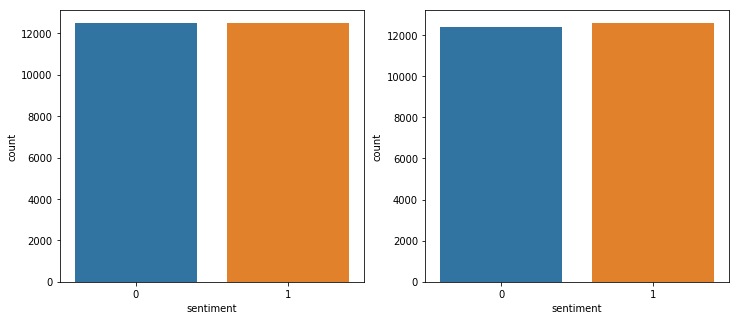

In [68]:
import seaborn as sns 
%matplotlib inline

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

In [70]:
# 리더보드 544등
544/578

0.9411764705882353

★결과 : 튜토리얼1에서 했던 Bag of Word보다 안 좋은 결과가 나왔다(BOW는 315등_score=0.92)